# Dimension and Fractals
This is our week 8 examples notebook and will be available on Github from the powderflask/cap-comp215 repository.
As usual, the first code block just imports the modules we will use.

In [147]:
import math
from itertools import tee
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from scipy.stats import linregress

### Helpers
The Point2D class we examined in class in week 6 and a couple small helpers for re-arranging iterables...

In [148]:
class Point2D:
    """ A point on the 2D Cartesian plane """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return '({x}, {y})'.format(x=round(self.x,2), y=round(self.y,2))

    def __add__(self, other):
        return Point2D(self.x+other.x, self.y+other.y)

    def distance(self, other):
        """ Return distance between this point and other Point2D """
        return math.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)

    def angle(self, other):
        """ return the angle of the line segment running between self and other """
        return np.arctan2(other.y-self.y, other.x-self.x)

    def mid(self, other, p=0.5):
        """" return a new point mid way on the line segment between self and other, p-way along the segment """
        return Point2D(self.x + (other.x-self.x)*p, self.y + (other.y-self.y)*p)

class PolarPoint2D(Point2D):
    """ A point on the 2D Cartesian plane specified in polar coordinates """
    def __init__(self, r, theta):
        """ define point by length r and angle, theta, in radians """
        super().__init__(x=r*np.cos(theta), y=r*np.sin(theta))


def flatten(container):
    """ return generator with items from an iterable of iterables """
    return (item for iterable in container for item in iterable)
assert tuple( flatten([(1,2,3), (4,), (5,6)]) ) == (1,2,3,4,5,6)

def pairwise(iterable):
    """
        Returns iterable of pairs (2-tuples) made of all adjacent pairs in argument
        from: https://docs.python.org/3.7/library/itertools.html#itertools-recipes
    """
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)
assert tuple( pairwise([1,2,3,4,5]) ) == ((1,2), (2,3), (3,4), (4,5))

## Dimension

  The essential idea of "fractured" dimensions has a long history in mathematics, but the term itself was brought to the fore by *Benoit Mandelbrot* based on his 1967 paper on self-similarity in which he discussed fractional dimensions.
  In that paper, Mandelbrot cites work by Lewis Fry Richardson describing the counter-intuitive notion that a coastline's measured length changes with the length of the measuring stick used... [**_https://en.wikipedia.org/wiki/Fractal_dimension_**](https://en.wikipedia.org/wiki/Fractal_dimension)

### Koch Snowflake

   One non-trivial example is the fractal dimension of a Koch snowflake. It has a topological dimension of 1, but it is by no means a rectifiable curve: the length of the curve between any two points on the Koch snowflake is infinite. No small piece of it is line-like, but rather it is composed of an infinite number of segments joined at different angles. The fractal dimension of a curve can be explained intuitively thinking of a fractal line as an object too detailed to be one-dimensional, but too simple to be two-dimensional. Therefore its dimension might best be described not by its usual topological dimension of 1 but by its fractal dimension, which is often a number between one and two; in the case of the Koch snowflake, it is about 1.262  [**_https://en.wikipedia.org/wiki/Koch_snowflake_**](https://en.wikipedia.org/wiki/Koch_snowflake)

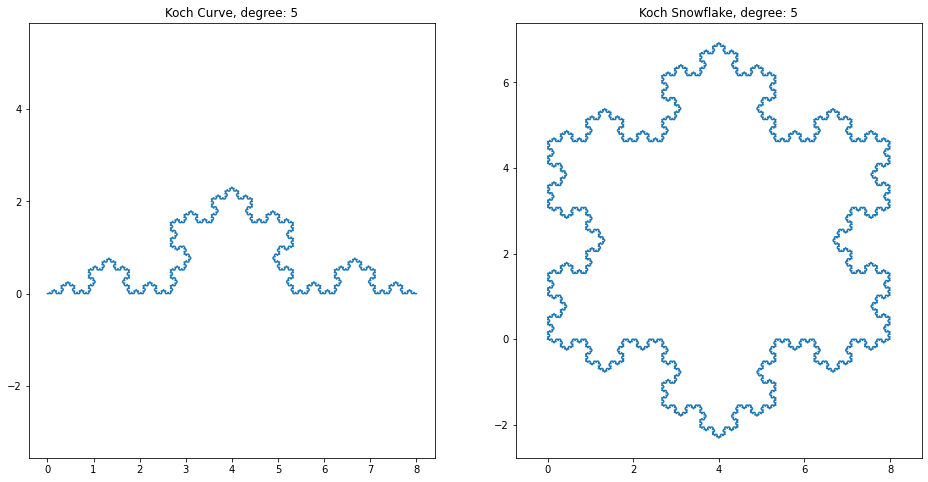

In [149]:
class KochCurve:
    """ A single Koch curve """
    RIGHT_ANGLE = np.pi / 2
    TRI_ANGLE  = np.pi / 3             # interior angle of an equilateral triangle
    TAN_TRI_ANGLE = np.tan(TRI_ANGLE)  # re-usable quantity:  tan( 60 )

    def __init__(self, degree=0, size=8):
        """ A koch curve scaled to given length - degree 0 (straight line) by default """
        self.size = size
        self.title = "Koch Curve"
        self.lines = self._get_lines(size)
        self.step(degree)

    def _get_lines(self, size):
        """ Helper: get a tuple of initial points defining the line segments on the curve """
        # vertices of the initial equilateral triangle
        A = Point2D(0, 0)
        B = Point2D(size, 0)

        # A "line" is just a tuple of Point2D objects
        return [(A, B)]

    def koch_curve(self, p1, p2):
        """
            return 5-tuple of points on the first-degree koch curve between p1 and p2
        """
        mid_point = p1.mid(p2) + PolarPoint2D(r=self.TAN_TRI_ANGLE * p1.distance(p2) / 6,
                                              theta=p1.angle(p2) + self.RIGHT_ANGLE)
        return (
            p1, p1.mid(p2, 1/3), mid_point, p1.mid(p2, 2/3), p2
        )

    def step(self, degree=1):
        """
            make the snowflake n degrees more fractal
        """
        for d in range(degree):
            n_line = len(self.lines)
            # replace each line segment with a koch curve
            new_lines = []
            for line in self.lines:
                new_lines += [self.koch_curve(p1, p2) for p1,p2 in pairwise(line)]
            self.lines = new_lines

    def get_points(self):
        """ return a generator for all the points currently calculated on this curve """
        return flatten(self.lines)

    def n_segs(self):
        """ return the number of line segments currently calculated on this curve """
        return sum(1 for _ in self.get_points()) - len(self.lines)  # 1 fewer segments than points in each line

    def draw(self, ax):
        """ Draw the curve on the given axes """
        x, y = zip(*((p.x, p.y) for p in self.get_points()))
        ax.plot(x, y)

    def plot(self, ax):
        """ Plot this curve on given axes """
        ax.set_title("{title}, degree: {degree}".format(title=self.title, degree=degree))
        ax.axis('equal')
        self.draw(ax)


class KochSnowflake(KochCurve):
    """ 3 Koch curves connected in an equilateral triagle form a Koch snowflake """

    def __init__(self, degree=0, size=8):
        """ A koch snowflake scaled to given size - degree 0 (triangle) byt default """
        super().__init__(degree, size)
        self.title = "Koch Snowflake"

    def _get_lines(self, size):
        """ Get a tuple of initial points defining the line segments on an equilateral triangle """
        A = Point2D(0, 0)
        B = Point2D(size, 0)
        C = Point2D(size * np.cos(self.TRI_ANGLE), size * np.sin(self.TRI_ANGLE))

        #  line" is a tuple of Point2D objects defining the segments of the triangle, counter-clockwise
        return [(A, C, B, A)]


# Generate and plot a sample curve and snowflake with same degree
degree = 5
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

curve= KochCurve(degree=degree)
curve.plot(axes[0])

snowflake = KochSnowflake(degree=degree)
snowflake.plot(axes[1])
plt.show()

In [150]:
class KochAnimation:
  """
    Animates a Koch Snowflake
  """
  def __init__(self, degree=5, size=6):
    self.snowflake = KochSnowflake(degree=0, size=size)
    fig, self.ax = plt.subplots(figsize=(size*1.5,size*1.5))
    self.ax.axis('equal')
    self.animation = animation.FuncAnimation(fig, self.animate, frames=degree+1)

  def animate(self, step):
    """ Step the model forward and draw the graph """
    if step > 0:
        self.snowflake.step()
    self.ax.clear()
    self.ax.set_title("Degree {}".format(step))
    self.snowflake.draw(self.ax)

  def show(self):
    """ return the matplotlib animation, ready for display """
    plt.close()
    rc('animation', html='jshtml')
    return self.animation

# Create the animation - careful, somewhere above degree 8 the number of points gets very large!

anim = KochAnimation(degree=5)
anim.show()

##Dimension of Koch Curve
**Mass Scaling factor** is 4 : each curve can be broken down into 4 self-similar curves...
**Size Scaling factor** is 3 : where each curve will be exacly 1/3 the size of the original

From [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4):
a koch curve can be divided into 4 self-similar segments, each 1/3 the length of the original, yielding dimensionality: (1/3)^D == 1/4 or D = log3(4)

In [151]:
D = math.log(4, 3)         # 2 ways to calculate log3(4)
D = math.log(4)/math.log(3)
D

1.2618595071429148

## Estimating the fractal dimension of a shape with a scaling "measuring stick"
Lewis Fry Richardson (1881-1953), an English meteorologist, pioneered a process for calculating dimensions with varied measurements. Using this technique an object's perimeter is measured with rulers of different lengths, then by graphing its slope the corresponding dimension is calculated. [Calculating Fractal Dimension](https://www.wahl.org/fe/HTML_version/link/FE4W/c4.htm#richardson)

The perimeter of a koch curve is propostional to the number of line segments, and the "ruler lengths" are naturally the lengths of line segments at each successive degree of the curve (1, 1/3, 1/9, 1/27, ...)

In [158]:
def calc_koch_scaling(max_degree):
    """ return a vector with the number of line segments for each degree koch curve from 1 to .. max """
    n_segs = []
    curve = KochCurve()
    for degree in range(1,max_degree+1):
        curve.step()
        n_segs.append(curve.n_segs())
    return n_segs

degrees = 8
n_segs = calc_koch_scaling(degrees)
print("Number of segments for n-degree curve:", [(deg, n) for deg, n in zip(range(1, degrees+1), n_segs)])

Number of segments for n-degree curve: [(1, 4), (2, 16), (3, 64), (4, 256), (5, 1024), (6, 4096), (7, 16384), (8, 65536)]


The scaling factor converges to 4 because each scaling operation breaks each segment into 4 new curves.

In [159]:
scaling_factor = [b/a for a,b in zip(n_segs,n_segs[1:])]
scaling_factor

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]

square dimension: 2.0
koch   dimension: 1.2618595071429146
linear dimension: 1.0


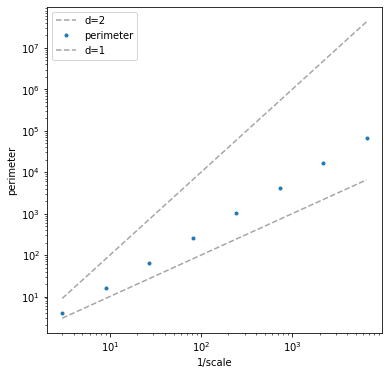

In [160]:
def plot_koch_scaling(n_segs):
    """ plot the perimeter of each koch curve degree by the inverse length scaling factor """
    plot_options = dict(xlabel='1/scale', ylabel='perimeter', xscale='log', yscale='log')
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=plot_options)

    fractal_degree = np.array(range(1, len(n_segs)+1))
    length_scale = 3**fractal_degree  # relative length scales by 1/3 for each degree - this is actually 1/length scale

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    ax.plot(length_scale, length_scale**2, label='d=2', **line_options)    # y =  x**2
    ax.plot(length_scale, n_segs, '.', label='perimeter')
    ax.plot(length_scale, length_scale, label='d=1', **line_options)       # y = x
    ax.legend()

    # linear regression to estimate the slope of 3 lines (square, koch perim, linear) to estimate their dimension
    for label, ys in [('square', length_scale**2), ('koch  ', n_segs), ('linear', length_scale)]:
        params = linregress(np.log(length_scale), np.log(ys))
        print('{label} dimension: {slope}'.format(label=label, slope=params[0]))


plot_koch_scaling(n_segs)